# Homework 1: Autoregressive models

In [1]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import show_samples, visualize_images, load_pickle

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Task 1. Theory (5pt)

### Problem 1: Sampling from KDE (2pt)

Let $\hat{p}_h(x) = \frac{1}{n h^d} \sum\limits_{i = 1}^{n} K\left(\frac{x - X_i}{h}\right)$ is the Kernel Density Estimator (see seminar 1) of a density $p_{\pi}$, where $X_1, \dots, X_n \sim p_{\pi}$, $X_i \in \mathbb{R}^d$.

Consider the following sampling scheme:
>
>1. Choose random number $k$ uniformly from the collection of numbers $\{1, 2, \dots, n\}$.
>
>2. Sample the random variable $\tilde{X}$ from the kernel $\frac{1}{h^d} K\left(\frac{x - X_k}{h}\right)$.
>

Prove, that $\tilde{X}$ is distributed according to $\hat{p}_h(x)$, i.e. the scheme above is the correct sampling scheme for $\hat{p}_h(x)$.

#### Solution Problem 1

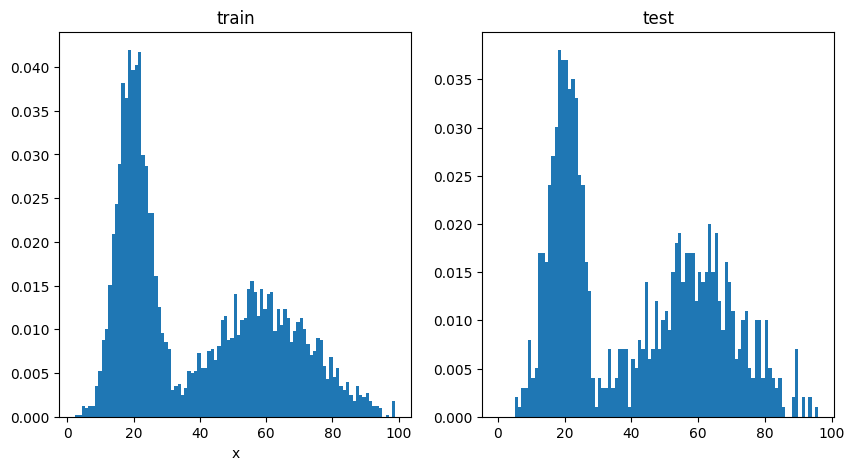

In [5]:
def generate_1d_data(count, bins):
    np.random.seed(42)
    a = 0.2 + 0.05 * np.random.randn(count)
    b = 0.6 + 0.15 * np.random.randn(count)
    mask = np.random.rand(count) < 0.5
    samples = np.clip((a * mask + b * (1 - mask)) * (bins - 1), 0.0, (bins - 1))
    data = samples.astype('int')
    split = int(0.8 * count)
    train_samples, test_samples = samples[:split], samples[split:]
    train_hist, test_hist = data[:split], data[split:]
    return train_samples, test_samples, train_hist, test_hist

def plot_1d_data(train_data, test_data):
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('train')
    ax1.hist(train_data, bins=bins, density=True)
    ax1.set_xlabel('x')
    ax2.set_title('test')
    ax2.hist(test_data, bins=np.arange(bins), density=True)
    plt.show()
    
BINS = 100
COUNT = 5000

train_data, test_data, _, _ = generate_1d_data(COUNT, BINS)
plot_1d_data(train_data, test_data)

In [4]:
from statsmodels.nonparametric.kde import kernel_switch, KDEUnivariate
list(kernel_switch.keys())

['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2', 'tric']

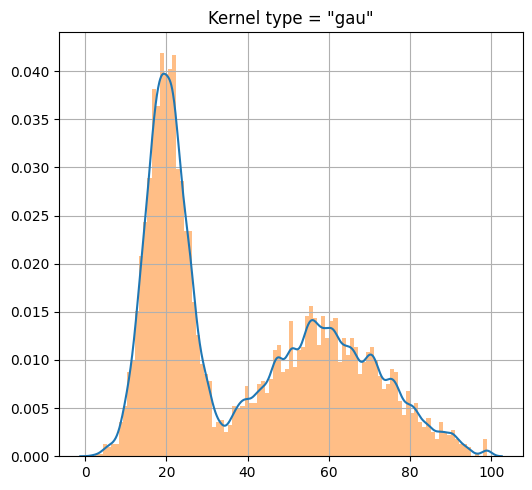

In [56]:
kde = KDEUnivariate(train_data)  # объект, выполняющий построение оценки

num_bins = int(train_data.max() - train_data.min()) + 1 # для построения гистограммы

fig = plt.figure(figsize=(15, 5))
kernel_types = ['gau'] # ['gau', 'uni', 'tri']
bw = 1.2

for i, kernel in enumerate(kernel_types):
    
    ax = fig.add_subplot(1, 3, i + 1)
    ax.set_title('Kernel type = "{}"'.format(kernel))
    
    # построение ядерной оценки плотности с заданным ядром
    # bw is "scott", "silverman", ... 
    kde.fit(kernel=kernel, bw=bw, fft=False, gridsize=2**10)
    ax.plot(kde.support, kde.density)
    # отрисовка гистограммы
    ax.hist(train_data, bins=num_bins, density=True, alpha=0.5)
    plt.grid(True)
    
plt.tight_layout()

In [64]:
# sampling
count = train_data.shape[0]
pdf = kde.density / kde.density.sum()

samples = np.random.choice(kde.support, size=COUNT, replace=True, p=pdf)

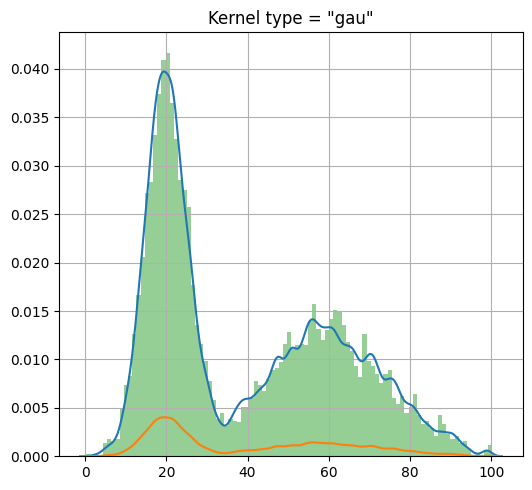

In [65]:
# ploting for genereted samples

fig = plt.figure(figsize=(15, 5))
for i, kernel in enumerate(kernel_types):
    
    ax = fig.add_subplot(1, 3, i + 1)
    ax.set_title('Kernel type = "{}"'.format(kernel))
    
    ax.plot(kde.support, kde.density, label='density')
    ax.plot(kde.support, pdf, label='pdf')
    # отрисовка гистограммы
    ax.hist(samples, bins=num_bins, density=True, alpha=0.5)
    plt.grid(True)
    
plt.tight_layout()

### Problem 2: MADE theory (2pt)

Consider the [MADE](https://arxiv.org/abs/1502.03509) model with a single hidden layer (we have discussed it at seminar 2). The input object is $\mathbf{x} \in \mathbb{R}^m$. We denote by $\mathbf{W} \in \mathbb{R}^{h \times m}$ the matrix of weights between the input and the hidden layer, and by $\mathbf{V} \in \mathbb{R}^{m \times h}$ the matrix of weights between the hidden and the output layer ($h$ is the number of neurons in the hidden layer). Let us generate the correct autoregressive masks $\mathbf{M}_{\mathbf{W}} \in \mathbb{R}^{h \times m}$ and $\mathbf{M}_{\mathbf{V}} \in \mathbb{R}^{m \times h}$ (the generation algorithm is given in Lecture 1) for the direct order of variables
$$
    p(\mathbf{x}) = p(x_1) \cdot p(x_2 | x_1) \cdot \dots \cdot p(x_m | x_{m-1}, \dots, x_1).
$$ 
(The order of neurons is given by indices at the probabilities in the formula. In this case, it is a direct order.)

Each mask is a binary matrix of 0 and 1. Let's introduce the matrix $\mathbf{M} = \mathbf{M}_{\mathbf{V}} \mathbf{M}_{\mathbf{W}}$. Prove that:
* $\mathbf{M}$ is strictly lower triangular (has zeros on the diagonal and above the diagonal);
* $\mathbf{M}_{ij}$  is equal to the number of paths in the network graph between the output neuron $\hat{x}_i$ and the input neuron $x_j$.

#### Solution Problem 2

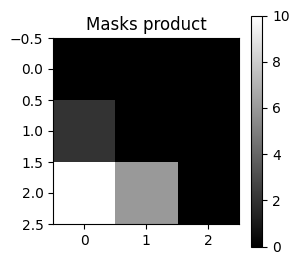

array([[ 0,  0,  0],
       [ 2,  0,  0],
       [10,  6,  0]])

In [36]:
def create_masks(nin_ordering, hidden_layers_ordering):
    nout_ordering = nin_ordering
    
    masks = []
    ordering = [nin_ordering, *hidden_layers_ordering, nout_ordering]
    for input_layer_orderig, output_layer_orderig in zip(ordering[:-2], ordering[1:-1]):
        mask = input_layer_orderig <= output_layer_orderig[:, np.newaxis] 
        masks.append(mask.astype(int))
    
    mask = ordering[-2] < ordering[-1][:, np.newaxis] 
    masks.append(mask.astype(int))
    
    return masks

def visualize_masks_prod(masks):
    M = masks[-1]
    for mask in reversed(masks[:-1]):
        M = M.dot(mask)
        
    plt.figure(figsize=(3, 3))
    plt.title(f'Masks product')
    plt.imshow(M, cmap='gray')
    plt.colorbar()
    plt.show()
    
    return M
    
# from example of seminar 2
nin_ordering = np.array([1, 2, 3])
hidden_layers_ordering = [np.array([2, 1, 2, 2]), np.array([1, 2, 2, 1])]

masks = create_masks(nin_ordering, hidden_layers_ordering)
visualize_masks_prod(masks)

### Problem 3: $\alpha$-divergence (1pt)

In the course, we will meet different divergences (not only $KL$). So let's get acquainted with the class of $\alpha$-divergences:
$$
    D_{\alpha}(p || q) = \frac{4}{1 - \alpha^2} \left( 1 - \int p(x)^{\frac{1 + \alpha}{2}}q(x)^{\frac{1 - \alpha}{2}}dx\right).
$$
For each $\alpha \in [-\infty; +\infty]$ the function $D_{\alpha} (p || q)$ is a measure of the similarity between two distributions. $D_{\alpha} (p || q)$ has different properties for different $\alpha$.

Prove that for $\alpha \rightarrow 1$ the divergence $D_{\alpha}(p || q) \rightarrow KL(p || q)$, and for $\alpha \rightarrow -1$ the divergence $D_{\alpha}(p || q) \rightarrow KL(q || p)$. 

**Hint:** use the fact that $t^\varepsilon = \exp(\varepsilon \cdot \ln t) = 1 + \varepsilon \cdot \ln t + O(\varepsilon^2)$.

#### Solution Problem 3

-

### Problem 4*: Histogram for continuous random vectors in $\mathbb{R}^d$ (extra 2pt)

Let $\xi \in \mathbb{R}^d$ is an absolutely continuous random vector in with probability density function $p_{\xi}(x)$ , such that $\,\text{supp}(p_{\xi}) \subseteq [0, 1]^{d}$ ($p_{\xi}(x) = 0 \,\, \forall x \in \mathbb{R}^d \backslash [0, 1]^d$). Additionally assume, that $p_{\xi}$ is *Lipschitz continuous* with Lipschitz constant $L$, i.e.:
$$
\vert p_{\xi}(x) - p_{\xi}(y) \vert \leq L \Vert x - y \Vert_2\ \forall x, y \in \mathbb{R}^d .
$$  

Let $X_1, X_2, \dots, X_n$ be i.i.d sample from $\xi$. Consider dividing the hypercube $[0, 1]^d$ into subcubes $C_1, C_2, \dots, C_N$ with the side length equals to $h$ (i.e. we obtain $N = \left(\frac{1}{h}\right)^{d}$ subcubes). The histogram density estimator is as follows: 

$$
\hat{p}_h(x) = \sum\limits_{j = 1}^{N} \frac{\hat{\theta_j}}{h^d} I\left( x \in C_j\right).
$$

In the equation above $I(\,\cdot\,)$ is the indicator function and $\hat{\theta_j} = \frac{1}{n} \sum\limits_{i = 1}^{n} I(X_i \in C_j)$.

Let's estimate the discrepancy between true density $p_{\xi}(x)$ and histogram density estimator $\hat{p}_h(x)$. Consider the $MSE(x, h) = \mathbb{E}(\hat{p}_h(x)) - p_{\xi}(x))^2$ (the expectation is taken over sample $X_1, \dots, X_n$). 

* (a) Find an upper bound on $MSE(x, h)$ in terms of $L, h, d, n$. (**Hint:** utilize bias - variance decomposition and deal with each term separately) 

* (b) Find $h = h_n$ which minimizes the upper bound on $MSE(x, h)$. At which rate $MSE(x, h_n)$ converges to zero?

#### Solution Problem 4

-

Now it time to move on to practical part of homework.

In our course we have a small util [package](https://github.com/r-isachenko/2022-DGM-Ozon-course/blob/main/homeworks/dgm_utils/utils.py) with some usefull functions for loading and visualizing the images and training plots. In each homework there is a cell with installing this package. Please read carefully what functions we have in this package. It could help you to solve the tasks.

## Task 2: PixelCNN on MNIST (5pt)

[PixelCNN](https://arxiv.org/abs/1601.06759) model uses masked causal convoultions on images, we have discussed this model on the lecture 2.

Here you have to train this model on MNIST images. See paper for details.

Download the data from [here](https://drive.google.com/file/d/1eTH_3i6yShm5yQikO0KdDEG3Hue9lNoZ/view?usp=sharing) (you could use the cell below).

In [1]:
# !gdown --id 1eTH_3i6yShm5yQikO0KdDEG3Hue9lNoZ -O data/hw1/task2/

/home/jovyan/.imgenv-chernyavskiy-2gpu-psql-1-0/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1eTH_3i6yShm5yQikO0KdDEG3Hue9lNoZ
To: /home/jovyan/chernov/my/dgm/deep_gen_models/chernov/data/hw1/task2/mnist.pkl
100%|██████████████████████████████████████| 55.4M/55.4M [00:00<00:00, 96.9MB/s]


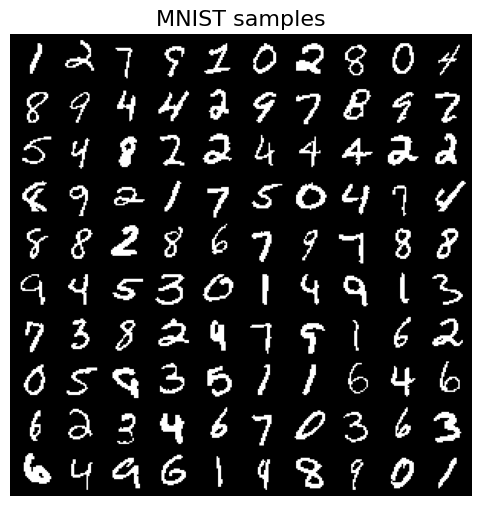

In [3]:
train_data, test_data = load_pickle('data/hw1/task2//mnist.pkl', flatten=False, binarize=True)
visualize_images(train_data, 'MNIST samples')

Masked Convolution Layer is the basic building block of PixelCNN model. Now you have to implement it.

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=5, simplified_mask=False):
        mask_type = str(mask_type).upper()
        assert mask_type in ['A', 'B']
        
        if simplified_mask:
            h = (kernel_size // 2) + 1
        else:
            h = kernel_size
        w = kernel_size
        kernel_size = (h, w)
            
        super().__init__(in_channels=in_channels, 
                         out_channels=out_channels, 
                         kernel_size=kernel_size, 
                         padding=kernel_size[1] // 2)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        return self._conv_forward(input, self.mask * self.weight, bias=self.bias)

    def create_mask(self, mask_type): 
        width = self.kernel_size[1]
        
        mixed_row = (width // 2)
        if mask_type == 'A':
            last_one_ind = (width // 2)
        elif mask_type == 'B':
            last_one_ind = (width // 2) + 1
        else: # Don't equal A or B
            raise ValueError('The argument mask_type must have the value "A" or "B".')
        
        self.mask[:, :, :mixed_row, :] = 1
        self.mask[:, :, mixed_row, :last_one_ind] = 1
        
        self.mask_type = mask_type


def test_masked_conv2d():
    layer = MaskedConv2d('A', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d('B', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))
    
    print('Test passed')


test_masked_conv2d()

Test passed


[Layer Normalization](https://arxiv.org/abs/1607.06450) helps to stabilize training process.

In [5]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters):
        super().__init__(n_filters)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

Now we are ready to construct the main PixelCNN model.

In [6]:
class PixelCNN(nn.Module):
    def __init__(
        self, 
        input_shape, 
        n_filters=16, 
        kernel_size=3, 
        n_layers=5, 
        use_layer_norm=True,
        simplified_mask=False,
    ):
      
        super().__init__()
        self.input_shape = input_shape    
        self.n_layers = n_layers
        
        double_h = n_filters *2
        h = n_filters
        
        input_block = [
            MaskedConv2d('A', 1, double_h, 7, simplified_mask),
        ]
        residual_block = [
            nn.Conv2d(double_h, h, kernel_size=1),
            MaskedConv2d('B', h, h, kernel_size, simplified_mask),
            nn.Conv2d(h, double_h, kernel_size=1),
        ]
        output_block = [
            nn.Conv2d(double_h, double_h, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(double_h, 2, kernel_size=1),
        ]
        
        blocks = [input_block, residual_block, output_block]
        if use_layer_norm:
            # add normalize after each layer
            for block in blocks[:-1]:
                for i in range(1, len(block) * 2, 2):
                    block.insert(i, LayerNorm(block[i-1].out_channels))
            blocks[-1].insert(1, LayerNorm(blocks[-1][0].out_channels))
            
        self.input_block = nn.Sequential(*blocks[0])
        self.residual_block = nn.Sequential(*blocks[1])
        self.output_block = nn.Sequential(*blocks[2])

    def forward(self, x):
        # read the forward method carefully
        batch_size = x.shape[0]
        en = (x.float() - 0.5) / 0.5 # normalizing input
        
        residual = self.input_block(en)
        residual = nn.ReLU()(residual)
        for i in range(self.n_layers):
            h = self.residual_block(residual)
            h += residual
            residual = nn.ReLU()(h)
        out = self.output_block(residual)
        
        return out.view(batch_size, 2, 1, *self.input_shape)

    def loss(self, x):
        out = self(x)
        total_loss = F.cross_entropy(out, x.long())
        return {'total_loss': total_loss}

    def sample(self, n):
        # read carefully the sampling process
        samples = torch.ones(n, 1, *self.input_shape).cuda() 
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()

In [45]:
# ====
# your code
# choose these parameters
# (h ere you could see the tips for the hyperparameters, they could help you, 
# but sometimes you could find more appropriate values,
# experiment with them.)
EPOCHS = 875            # > 5
BATCH_SIZE = 64         # any adequate value
LR = 1e-4               # < 1e-2
N_LAYERS = 9            # < 10
N_FILTERS = 64          # < 128
USE_LAYER_NORM = True
# ====

experiment_name = '4'
experiment_path = Path('res/hw1/task2') / experiment_name
experiment_path.mkdir(parents=True, exist_ok=True)

param = dict(epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, n_layers=N_LAYERS, n_filters=N_FILTERS, use_layer_norm=USE_LAYER_NORM)
with open(experiment_path / 'param.json', 'w') as f:
    json.dump(param, f)

# model = PixelCNN(
#     input_shape=(28, 28), 
#     n_filters=N_FILTERS, 
#     kernel_size=5, 
#     n_layers=N_LAYERS, 
#     use_layer_norm=USE_LAYER_NORM
# )

model = model.to(DEVICE)

# loss_for_assert = model.loss(torch.zeros(1, 1, 28, 28).to(DEVICE))
# assert isinstance(loss_for_assert, dict)
# assert 'total_loss' in loss_for_assert

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = training.train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA,
)

assert test_losses['total_loss'][-1] < 0.10

A Jupyter Widget

train_loss 0.0716, test_loss 0.0729
train_loss 0.0716, test_loss 0.0729
train_loss 0.0716, test_loss 0.0728
train_loss 0.0715, test_loss 0.0727
train_loss 0.0715, test_loss 0.0727
train_loss 0.0715, test_loss 0.0728
train_loss 0.0715, test_loss 0.0727
train_loss 0.0715, test_loss 0.0728
train_loss 0.0715, test_loss 0.0729
train_loss 0.0715, test_loss 0.0729
train_loss 0.0715, test_loss 0.0729
train_loss 0.0714, test_loss 0.0729
train_loss 0.0714, test_loss 0.0728
train_loss 0.0714, test_loss 0.0727
train_loss 0.0714, test_loss 0.0727
train_loss 0.0714, test_loss 0.0727
train_loss 0.0714, test_loss 0.0727
train_loss 0.0714, test_loss 0.0729
train_loss 0.0714, test_loss 0.0727
train_loss 0.0714, test_loss 0.0726
train_loss 0.0713, test_loss 0.0727
train_loss 0.0713, test_loss 0.0728
train_loss 0.0713, test_loss 0.0727
train_loss 0.0713, test_loss 0.0728
train_loss 0.0713, test_loss 0.0727
train_loss 0.0713, test_loss 0.0727
train_loss 0.0713, test_loss 0.0727
train_loss 0.0713, test_loss

In [ ]:
train_loss 0.0718, test_loss 0.0730

Even if the test loss is bigger than the value in assert, try to visualize train/test curves, it could find you to find the bug.

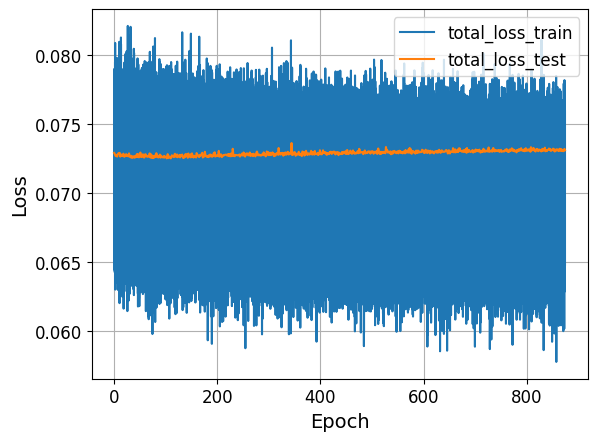

In [46]:
plot_training_curves(train_losses, test_losses, save_to=experiment_path / 'training_curves.jpg');

Now we sample the new images from the model. You have to emphasize that the sampling from the autoregressive model is slow, because it is a sequential process.

In [49]:
samples = model.sample(25)
# show_samples(samples, title='MNIST samples', nrow=5, save_to=experiment_path / 'gen_sampels.jpg')

I didn't understand:
1. why is different results of sampling?
2. why are the losses not decreasing, but the quality is increasing?

## Task 3: PixelCNN receptive field and autocompletion (3pt)

The PixelCNN model is a powerful model. But the model has drawbacks.

1. The model is sequential and sampling is really slow (it is a drawback of all AR models).

2. Second, the receptive field of the model is not so large. Even if the model is well-trained, the samples do not have long-range history. 

### Receptive field

To validate the second point and check our implementation of masked convolutions, let try to visualize the receptive field of the model. 

We should see that with increasing number of convolutional layers, the receptive field grows. The receptive field can be empirically measured by backpropagating an arbitrary loss for the output features of a specific pixel with respect to the input. We implement this idea below, and visualize the receptive field below.

In [ ]:
def plot_receptive_field(model, model_name):
    # ====
    # your code
    # 1) create tensor with zeros and set required_grad to True.
    # 2) apply model to the tensor
    # 3) apply backward() to the center pixel of model output
    # 4) take the gradient with respect to input
    # 5) binary receptive field is an indicator map in which we stay 1's if gradient more than 1e-8
    # 6) weighted receptive field is the normalized gradient (values lies in [0, 1])x

    # ====

    # we stack the maps to get RGB image
    binary_map = np.stack([binary_map, binary_map, binary_map], axis=-1)
    weighted_map = np.stack([weighted_map, weighted_map, weighted_map], axis=-1)

    # center point will be red
    binary_map[x_center, y_center] = [1, 0, 0]
    weighted_map[x_center, y_center] = [1, 0, 0]

    fig, ax = plt.subplots(1,2, figsize=(10, 6))
    ax[0].imshow(weighted_map, vmin=0.0, vmax=1.0)
    ax[1].imshow(binary_map, vmin=0.0, vmax=1.0)

    ax[0].set_title(f"Weighted receptive field for {model_name}")
    ax[1].set_title(f"Binary receptive field for {model_name}")
    
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [ ]:
for n_layers in [1, 3, 5, 6]:
    model = PixelCNN(
        input_shape=(28, 28), 
        n_filters=32, 
        kernel_size=5, 
        n_layers=n_layers, 
        use_layer_norm=True
    )
    if USE_CUDA:
        model = model.cuda()
    plot_receptive_field(model, model_name=f"PixelCNN {n_layers} layers")

You have to see that PixelCNN has strange blind spot in binary receptive field plot on the right side. This is a known issue of PixelCNN model. Please, try to understand why it happens. 

One way to solve this problem is a [GatedPixelCNN](https://arxiv.org/pdf/1606.05328.pdf) model (see paper, if you are interested in).

### Image autocompletion

The last feature of autoregressive model that we try is auto-completing an image. As autoregressive models predict pixels one by one, we can set the first pixels to predefined values and check how the model completes the image. 

For implementing this, we just need to skip the iterations in the sampling loop that already have a value unequals to -1. 
We redefine the sample method in out PixelCNN class to allow it to take init of the sample.

In [ ]:
class PixelCNNAutoComplete(PixelCNN):
    def sample(self, n, init=None):
        # ====
        # your code
        # this method almost the same as the method of the base PixelCNN model
        # but now if init is given, this tensor will be used as a starting image. 
        # The pixels to fill should be -1 in the input tensor.
        
        # ====

You have to repeat the model training.

In [ ]:
model = PixelCNNAutoComplete(
    input_shape=(28, 28), 
    n_filters=N_FILTERS, 
    kernel_size=5, 
    n_layers=N_LAYERS, 
    use_layer_norm=USE_LAYER_NORM
)

train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA
)

assert test_losses['total_loss'][-1] < 0.10

We randomly take images from the training set, mask the lower half of the image (set -1's), and let the model autocomplete it. We do this several times for each image to see the diversity of samples.

In [ ]:
def autocomplete_image(image, model, n_samples):
    # Remove lower half of the image
    image_init = image.copy()
    image_init[:, image.shape[1] // 2:, :] = -1
    samples = np.stack([image, np.maximum(image_init, 0)])
    show_samples(samples, title="Original image and input image to sampling", nrow=2)
    # Generate completions
    image_init = torch.tensor(image_init)
    image_init = image_init.unsqueeze(dim=0).expand(n_samples, -1, -1, -1).cuda()
    img_generated = model.sample(n_samples, image_init)
    show_samples(img_generated, title="n_samples", nrow=4)


for i in range(1, 4):
    autocomplete_image(train_data[i], model, n_samples=4)